# West Nile Virus Prediction

### 1. Import Data and Libraries

In [841]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from math import radians, sin, cos, asin, sqrt
from sklearn.metrics import confusion_matrix, roc_curve, auc

%matplotlib inline

In [842]:
spray = pd.read_csv('./west_nile/west_nile/input/spray.csv')
weather = pd.read_csv('./west_nile/west_nile/input/weather.csv')
train = pd.read_csv('./west_nile/west_nile/input/train.csv')
sample = pd.read_csv('./west_nile/west_nile/input/SampleSubmission.csv')
test = pd.read_csv('./west_nile/west_nile/input/test.csv')

In [843]:
#use to assign weather data to traps based on distance from weather station to trap

def haversine(lat1, lon1, lat2, lon2):
    '''Calculates the distance between two lat-long points.'''
    
    R = 3959.87433 # this is in miles.  For Earth radius in kilometers use 6372.8 km

    dLat = radians(lat2 - lat1)
    dLon = radians(lon2 - lon1)
    lat1 = radians(lat1)
    lat2 = radians(lat2)

    a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
    c = 2*asin(sqrt(a))

    return R * c

In [844]:
train.head()

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0


### 2. Perform EDA /Format /Clean Data

In [845]:
def quick_EDA(df):
    #Input a dataframe, Returns: shape of data, number of nulls
    nulls = df.isnull().sum().sum()
    
    print('Rows:', df.shape[0], 'Columns:', df.shape[1])
    print('Total NaNs:', nulls)

In [846]:
#Converting columns to datetime format
def convert_datetime(df):
    df['Date'] = pd.to_datetime(df['Date'])

In [847]:
#converting spray columns to date time and making date/time columns
def convert_spray(df):
    df['Date'] = pd.to_datetime(spray['Date'])
    df['am_pm'] = df['Time'].apply(lambda x: str(x).split()[-1])
    df['Time'] = df['Time'].apply(lambda x: str(x).split()[0])
    df['Time'] = pd.to_datetime(spray['Time'], format = '%H:%M:%S')

In [848]:
quick_EDA(train)

Rows: 10506 Columns: 12
Total NaNs: 0


In [849]:
quick_EDA(spray)

Rows: 14835 Columns: 4
Total NaNs: 584


In [850]:
quick_EDA(weather)

Rows: 2944 Columns: 22
Total NaNs: 0


In [851]:
quick_EDA(test)

Rows: 116293 Columns: 11
Total NaNs: 0


In [852]:
#converting date time
dfs = [train, test, weather]

for df in dfs:
    convert_datetime(df)

In [853]:
#converting spray data
convert_spray(spray)

In [854]:
#testing to see if any traps are ever tested more than once on the same day
    # none are, this will allow us to determine the number of mosquitos in traps where there are more than 50
    # because we can now combine rows on Trap Id and Date to get total no. mosquitos tested
datetrap = train[['Date', 'Trap']]
y = datetrap.merge(pd.get_dummies(train['Trap']), how = 'left', right_index = True, left_index = True)

datetrapcols = y.shape[1]
datetraprows = y.shape[0]
errors = 0

for i in range(datetraprows):
    for g in range(2,datetrapcols):
        if y.iloc[i,g] > 1:
            errors += 1
print('Traps tested > 1/day:', errors)

Traps tested > 1/day: 0


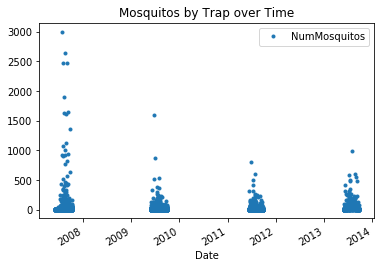

In [855]:
#plotted mosquitos by trap by date
train[['Date', 'Trap', 'NumMosquitos']].groupby(by = ['Date','Trap'])['Date','Trap','NumMosquitos'] \
    .sum().reset_index().sort_values('NumMosquitos', ascending = False).set_index('Date').plot(style = '.')
    
plt.title('Mosquitos by Trap over Time');

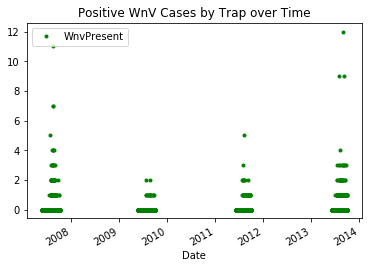

In [856]:
#plotted WNV incidents by trap
train[['Date', 'Trap','WnvPresent']].groupby(by = ['Date','Trap'])['Date','Trap','WnvPresent'] \
    .sum().reset_index().sort_values('WnvPresent', ascending = False).set_index('Date').plot(color = 'green', style = '.')
    
plt.title('Positive WnV Cases by Trap over Time');

### 3. Feature Engineering

##### Pair weather data with trap locations

In [857]:
#assign weather station to trap based on location
'''
stat1lat = 41.995
stat1long = -87.933
stat2lat = 41.786
stat2long = -87.752 

train['Station'] = 1

for i in range(train.shape[0]):
    if haversine(stat1lat, stat1long, train.loc[i, 'Latitude'], train.loc[i, 'Longitude']) > haversine(stat2lat, stat2long, train.loc[i, 'Latitude'], train.loc[i, 'Longitude']):
        train.loc[i,'Station'] = 2'''

"\nstat1lat = 41.995\nstat1long = -87.933\nstat2lat = 41.786\nstat2long = -87.752 \n\ntrain['Station'] = 1\n\nfor i in range(train.shape[0]):\n    if haversine(stat1lat, stat1long, train.loc[i, 'Latitude'], train.loc[i, 'Longitude']) > haversine(stat2lat, stat2long, train.loc[i, 'Latitude'], train.loc[i, 'Longitude']):\n        train.loc[i,'Station'] = 2"

In [858]:
#train = train.merge(weather, how = 'left', on = ['Date','Station'])

##### Split out Parent Traps and Child Traps

In [859]:
#Create columns to show parent trap and child traps
train['Parent_Trap'] = train['Trap'].apply(lambda x: x[:4])
train['Child_Trap'] = train['Trap'].apply(lambda x: x[4:])

test['Parent_Trap'] = test['Trap'].apply(lambda x: x[:4])
test['Child_Trap'] = test['Trap'].apply(lambda x: x[4:])

In [860]:
#show number of child traps to each parent trap
#need to de-duplicate list of traps initally to accomplish this
train[['Parent_Trap', 'Child_Trap']].drop_duplicates().groupby(by = 'Parent_Trap')['Child_Trap'].count().reset_index(). \
    sort_values(by = 'Child_Trap',ascending = False).reset_index(drop = True).head()

,Parent_Trap,Child_Trap
0,T094,2
1,T054,2
2,T001,1
3,T148,1
4,T143,1


##### Get Dummies for mosquito species

In [861]:
def mosquitos_vars(df):
    #split wnv transmitting mosquito species lines into separate columns
    df['CULEX PIPIENS'] = 0
    df['CULEX RESTUANS'] = 0
    
    for row in range(df.shape[0]):
        if df.loc[row, 'Species'] == 'CULEX PIPIENS/RESTUANS':
            df.loc[row, 'CULEX PIPIENS'] == 1
            df.loc[row, 'CULEX RESTUANS'] == 1
        elif df.loc[row, 'Species'] == 'CULEX PIPIENS':
            df.loc[row, 'CULEX PIPIENS'] == 1
        elif df.loc[row, 'Species'] == 'CULEX RESTUANS':
            df.loc[row, 'CULEX RESTUANS'] == 1
            
    
    df.drop(columns = ['Species'], inplace = True)

In [862]:
#make dummies for mosquito species
mosquitos_vars(train)
mosquitos_vars(test)

##### Get Dummies for Other Variables

In [863]:
train = pd.get_dummies(train, columns = ['Trap', 'Block'])
test = pd.get_dummies(test, columns = ['Trap', 'Block'])

train.drop(columns = ['Street'], inplace = True)
test.drop(columns = ['Street'], inplace = True)

##### Get Dummies for Time (Week, Month)

In [864]:
def week_month(df):
    #breaking week, month, and year into separate columns
    
    df['Week'] = df['Date'].dt.week
    df['Month'] = df['Date'].dt.month

    #drop date column
    df.drop(columns = 'Date', inplace = True)

    #get dummies
    return pd.get_dummies(df, columns = ['Week', 'Month'])

In [865]:
train = week_month(train)
test = week_month(test)

##### Drop Misc. Columns

In [866]:
train.drop(columns = ['Address', 'AddressNumberAndStreet', 'Latitude', \
                      'Longitude', 'AddressAccuracy', 'Parent_Trap', 'Child_Trap'], inplace = True)\

test.drop(columns = ['Address', 'AddressNumberAndStreet', 'Latitude', \
                      'Longitude', 'AddressAccuracy', 'Parent_Trap', 'Child_Trap'], inplace = True)

### 4. Modeling

In [867]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample

from keras.models import Sequential
from keras.layers import Dense

##### Resampling Data for Classification Models

In [868]:
#this is the baseline accuracy to beat for classification models
#if we selected "WnV is not present for all samples" we would be correct ~95% of the time
format(1 - train['WnvPresent'].sum()/train.shape[0], '.5f')

'0.94755'

In [869]:
#have to convert to numpy array for keras/tensorflow/classification
X = train.drop(columns = 'WnvPresent')
y = train['WnvPresent']


In [870]:
#prep data to enter models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [871]:
#rejoin train data on index so it can be downsampled to match classes
traindata = X_train.merge(pd.DataFrame(y_train), how = 'left', right_index = True, left_index = True)

#separate minority and majority classes
train_majority = traindata[traindata['WnvPresent'] == 0]
train_minority = traindata[traindata['WnvPresent'] == 1]

#upsample minority class
train_minority_upsampled = resample(train_minority, 
                                     replace = True, 
                                     n_samples = train_majority.shape[0],
                                     random_state = 65)
#combine classes
train_data_upsampled = pd.concat([train_majority, train_minority_upsampled])
#split back into X_train and y_train
X_train = train_data_upsampled.drop(columns = 'WnvPresent')
y_train = train_data_upsampled['WnvPresent']

In [872]:
def drop_columns(df1, df2):
    #drop columns in either test/train that are not in the other
    
    df1cols = df1.columns.tolist()
    df2cols = df2.columns.tolist()
    
    notindf1cols = []
    notindf2cols = []
    
    for col in df1cols:
        if col not in df2cols:
            notindf2cols.append(col)
    
    for col in df2cols:
        if col not in df1cols:
            notindf1cols.append(col)
            
    df1.drop(columns = notindf2cols, inplace = True)
    df2.drop(columns = notindf1cols, inplace = True)

In [873]:
drop_columns(test, X_test)
drop_columns(X_train, X_test)

C:\Users\peckr\AppData\Local\conda\conda\envs\ga\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [874]:
X_test.shape

(3152, 226)

#### A. Neural Network

In [876]:
#standardizing data to normalize with a mean of 0 and a stdDev of 1
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

test = ss.transform(test)

In [877]:
#create model
model = Sequential()

In [878]:
#network topolgy
input_units = X_train.shape[1]
hidden_units = round(input_units)

model.add(Dense(hidden_units, 
                input_dim = input_units, 
                activation = 'relu'))

model.add(Dense(1, activation = 'sigmoid'))

In [879]:
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['binary_accuracy'])

In [880]:
history = model.fit(X_train, y_train,
                   validation_data = (X_test, y_test),
                   epochs = 10, 
                   batch_size = None, 
                   verbose = 1)

Train on 13938 samples, validate on 3152 samples
Epoch 1/10
13938/13938 [==============================] - 12s 860us/step - loss: 0.4479 - binary_accuracy: 0.7828 - val_loss: 0.4541 - val_binary_accuracy: 0.7418
Epoch 2/10
13938/13938 [==============================] - 9s 643us/step - loss: 0.3631 - binary_accuracy: 0.8381 - val_loss: 0.4454 - val_binary_accuracy: 0.7786
Epoch 3/10
13938/13938 [==============================] - 9s 672us/step - loss: 0.3252 - binary_accuracy: 0.8630 - val_loss: 0.4728 - val_binary_accuracy: 0.7871
Epoch 4/10
13938/13938 [==============================] - 9s 648us/step - loss: 0.3078 - binary_accuracy: 0.8696 - val_loss: 0.4643 - val_binary_accuracy: 0.8011
Epoch 5/10
13938/13938 [==============================] - 9s 675us/step - loss: 0.2979 - binary_accuracy: 0.8752 - val_loss: 0.4371 - val_binary_accuracy: 0.8058
Epoch 6/10
13938/13938 [==============================] - 10s 722us/step - loss: 0.2922 - binary_accuracy: 0.8780 - val_loss: 0.4314 - val_b

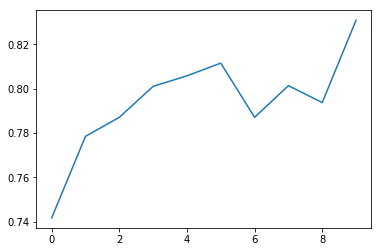

In [881]:
#plotting accuracy over epochs
plt.plot(history.history['val_binary_accuracy'])

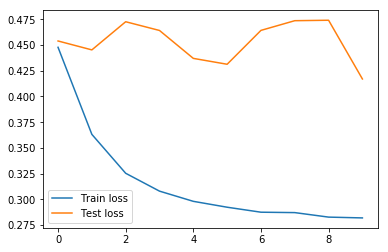

In [882]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.plot(train_loss, label = 'Train loss')
plt.plot(test_loss, label = 'Test loss')
plt.legend();

In [883]:
# as predicted from total data set only around 5% of all samples test positive for WnV
# preliminarily it appears that from upsampling the wnv cases to get a 50/50 test split
# for our neural network we are achieving around 88% accuracy against the test set
# compared to our baseline of 95% we would be better off guessing that all do not have WnV
1 - y_test.sum()/y_test.shape[0]

0.9473350253807107

In [884]:
#need to implement a confusion matrix in order to score this appropriately, will never beat 95%
#get keras predictions to make a roc curve/get that roc auc
fpr, tpr, _ = roc_curve(y_test, model.predict(X_test))

#calculate AUC
roc_auc = auc(fpr, tpr)
#print a confusion matrix
#confusion_matrix(np.array(y_test), model.predict(X_test))

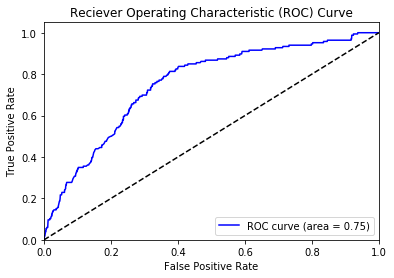

In [885]:
#plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, color = 'blue')
plt.plot([0, 1], [0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Reciever Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#### B. CART/Decision Trees

In [911]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

In [912]:
def CART_model_picker(model_list, X_train, y_train, X_test, y_test):
    '''Returns cross-val score and score for all input CART models, returns in sorted order of best performing'''
    results = []
    
    for (k,v) in model_list.items():
        scores = cross_val_score(v, X_train, y_train, cv = 5, n_jobs = -1)
        v.fit(X_train, y_train)
        
        #calculate AUC
        fpr, tpr, _ = roc_curve(y_test, v.predict(X_test))
        roc_auc = auc(fpr, tpr)

        results.append((k, scores.mean(), v.score(X_test, y_test), roc_auc))
    
    results.sort(key = lambda x: x[3], reverse = True)
    
    return results

In [913]:
#setting up stratified kfold
cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

In [914]:
#figure out which CART model performs the best

models = {'Decision Tree': DecisionTreeClassifier(),
          'Extra Trees': ExtraTreesClassifier(),
          'Gradient Boost': GradientBoostingClassifier(),
          'AdaBoost': AdaBoostClassifier(),
          'Random Forest':RandomForestClassifier(),
          'Bagging': BaggingClassifier()
         }


CART_model_picker(models, X_train, y_train, X_test, y_test)

[('Gradient Boost',
  0.7651010741347648,
  0.7106598984771574,
  0.7249695365521025),
 ('AdaBoost', 0.7523998862935295, 0.6925761421319797, 0.7211141955632309),
 ('Bagging', 0.8858517325302472, 0.7915609137055838, 0.6425063953066116),
 ('Decision Tree', 0.8875012488142702, 0.7953680203045685, 0.6388265721963541),
 ('Extra Trees', 0.8903712557458331, 0.7969543147208121, 0.6368192125501335),
 ('Random Forest', 0.8897253226575593, 0.7953680203045685, 0.6359819720946747)]

##### XGBoost Model

In [915]:
xgmodel= xgb.XGBClassifier(seed= 42)

eval_set = [(X_train, y_train), (X_test, y_test)]
scores = cross_val_score(xgb.XGBClassifier(), X_train, y_train, cv = 5, n_jobs = -1)

In [916]:
model.fit(X_train, y_train, eval_metric="auc", eval_set=eval_set, verbose=True)

[0]	validation_0-auc:0.761068	validation_1-auc:0.756029
[1]	validation_0-auc:0.761068	validation_1-auc:0.756029
[2]	validation_0-auc:0.766616	validation_1-auc:0.769059
[3]	validation_0-auc:0.773933	validation_1-auc:0.774446
[4]	validation_0-auc:0.775613	validation_1-auc:0.775705
[5]	validation_0-auc:0.775613	validation_1-auc:0.775705
[6]	validation_0-auc:0.782103	validation_1-auc:0.782464
[7]	validation_0-auc:0.784378	validation_1-auc:0.783665
[8]	validation_0-auc:0.785293	validation_1-auc:0.785473
[9]	validation_0-auc:0.786125	validation_1-auc:0.78519
[10]	validation_0-auc:0.785806	validation_1-auc:0.784777
[11]	validation_0-auc:0.786358	validation_1-auc:0.784475
[12]	validation_0-auc:0.78939	validation_1-auc:0.7855
[13]	validation_0-auc:0.792524	validation_1-auc:0.787175
[14]	validation_0-auc:0.792898	validation_1-auc:0.787251
[15]	validation_0-auc:0.793397	validation_1-auc:0.786625
[16]	validation_0-auc:0.793768	validation_1-auc:0.786847
[17]	validation_0-auc:0.793833	validation_1-a

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1)

In [917]:
model.score(X_test, y_test)

C:\Users\peckr\AppData\Local\conda\conda\envs\ga\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.6989213197969543

In [918]:
#calculate AUC
fpr, tpr, _ = roc_curve(y_test, model.predict(X_test))
roc_auc = auc(fpr, tpr)

C:\Users\peckr\AppData\Local\conda\conda\envs\ga\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [919]:
roc_auc

0.7244631573850661

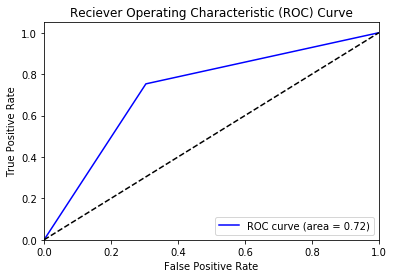

In [920]:
#plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, color = 'blue')
plt.plot([0, 1], [0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Reciever Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

##### Generating Model Submission

In [ ]:
def create_submission(model)
    '''Generates csv for submission from model using model.predict_proba'''
    #predicting values for submission
    submission = pd.DataFrame(model.predict_proba(test), columns = ['WnvPresent'])
    
    submission.set_index(np.arange(1, test.shape[0] + 1), inplace=True)
    submission = submission.reset_index().rename(columns = {'index':'Id'})
    submission.to_csv('~/Desktop/Git_lessons/Project4/westnilevirussubmission.csv', index = False)
    